# Graph Learning
## Lab 5: Heat Diffusion

In this lab, you will learn to use heat diffusion for **contrastive ranking** and **node classification**.

## Import

In [1]:
from IPython.display import SVG

In [2]:
import numpy as np
from scipy import sparse

In [3]:
from sknetwork.data import load_netset, grid, karate_club
from sknetwork.regression import Dirichlet
from sknetwork.classification import DiffusionClassifier
from sknetwork.ranking import PageRank
from sknetwork.utils import directed2undirected
from sknetwork.visualization import visualize_graph

## Data

We will work on the following graphs (see the [NetSet](https://netset.telecom-paris.fr/) collection for details):
* Openflights (graph)
* WikiVitals (directed graph + bipartite graph)

In [4]:
openflights = load_netset('openflights')
wikivitals = load_netset('wikivitals')

Parsing files...
Done.
Parsing files...
Done.


## 1. Graphs

## Grid

We first illustrate the notion of **contrastive ranking** on a $k\times k$ grid.

In [5]:
k = 5
dataset = grid(k, k, True)
adjacency = dataset.adjacency
position = dataset.position

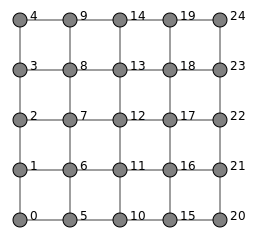

In [6]:
image = visualize_graph(adjacency, position, names=np.arange(k * k), width=200, height=200)
SVG(image)

## To do

* Display the solution to the Dirichlet problem with 1 hot source and 1 cold source, located on the opposite corners of the square.
* Add a hot source at the top-left corner of the square. What is the free node of highest temperature?

In [7]:
dirichlet = Dirichlet()

In [8]:
bottom_left = 0
top_right = k * k - 1

In [9]:
values = {bottom_left: 0, top_right: 1}

In [10]:
temperatures = dirichlet.fit_predict(adjacency, values=values)

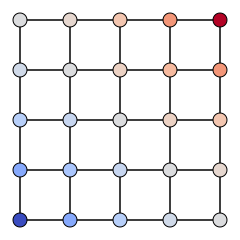

In [11]:
image = visualize_graph(adjacency, position, scores=temperatures, width=200, height=200)
SVG(image)

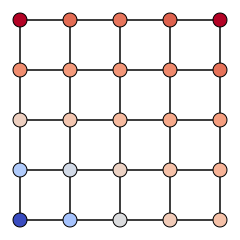

In [12]:
top_left = k - 1
values[top_left] = 1
temperatures = dirichlet.fit_predict(adjacency, values=values)
image = visualize_graph(adjacency, position, scores=temperatures, width=200, height=200)
SVG(image)

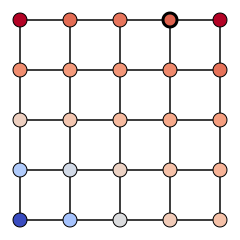

In [13]:
mat = np.ones(k * k, dtype=bool)
mat[list(values.keys())] = 0
p = np.argmax(temperatures[mat])
hot_node = np.flatnonzero(mat)[p]

image = visualize_graph(adjacency, position, scores=temperatures, width=200, height=200, seeds=hot_node)
SVG(image)

## Karate Club


We now consider the **classification** of nodes by heat diffusion. We use the [karate club graph](https://en.wikipedia.org/wiki/Zachary%27s_karate_club) that has ground-truth labels.

In [14]:
dataset = karate_club(True)

In [15]:
adjacency = dataset.adjacency
position = dataset.position
labels_true = dataset.labels

In [16]:
n = len(labels_true)

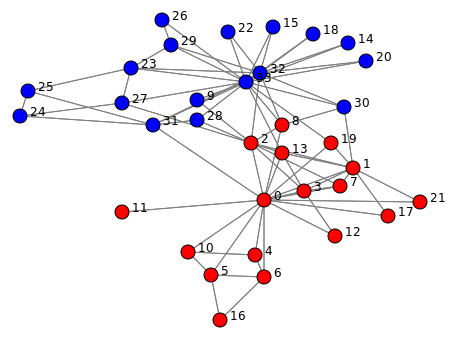

In [17]:
image = visualize_graph(adjacency, position, labels=labels_true, names=np.arange(n))
SVG(image)

## To do

* Select one node in each ground-truth cluster, and predict the labels of the other nodes by heat diffusion.
* Display the graph with the predicted labels. 
* What is the accuracy of the classification?

In [18]:
classifier = DiffusionClassifier()

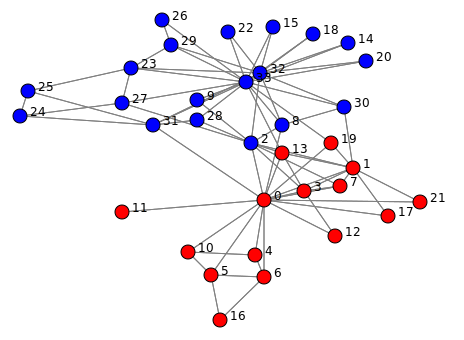

In [19]:
seeds = -np.ones(n, dtype=int)
for label in np.unique(labels_true):
    idx = np.where(labels_true == label)[0][0]
    seeds[idx] = label

classifier = DiffusionClassifier()
labels_pred = classifier.fit_predict(adjacency, seeds)

image = visualize_graph(adjacency, position, labels=labels_pred, names=np.arange(n))
SVG(image)

In [20]:
accuracy = np.mean(labels_true == labels_pred)
print(f"Accuracy of the classification: {accuracy:.4f}")

Accuracy of the classification: 0.9412


## To do

The classifier applies temperature centering after diffusion.

* Repeat the same experiment without temperature centering.
* Do the same experiments with 3 nodes in a ground-truth cluster and 1 in the other.
* Comment the results.

In [21]:
classifier = DiffusionClassifier(centering=False)

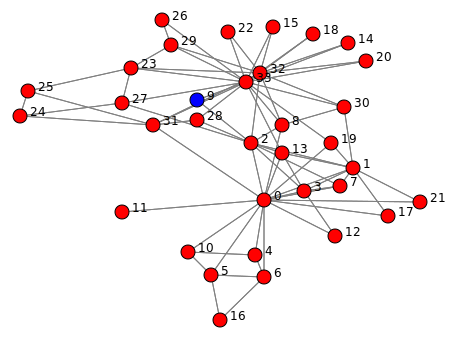

In [22]:
seeds = -np.ones(n, dtype=int)
for label in np.unique(labels_true):
    idx = np.where(labels_true == label)[0][0]
    seeds[idx] = label
    
labels_pred = classifier.fit_predict(adjacency, seeds)

image = visualize_graph(adjacency, position, labels=labels_pred, names=np.arange(n))
SVG(image)


In [23]:
accuracy = np.mean(labels_true == labels_pred)
print(f"Accuracy of the classification: {accuracy:.4f}")

Accuracy of the classification: 0.5294


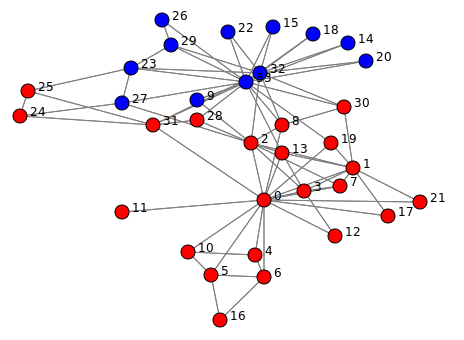

In [24]:
# Choisir 3 seeds dans le cluster 0 et 1 seed dans le cluster 1
seeds = -np.ones(n, dtype=int)
labels_unique = np.unique(labels_true)
# 3 seeds pour le premier cluster
idx0 = np.where(labels_true == labels_unique[0])[0][:3]
seeds[idx0] = labels_unique[0]
# 1 seed pour le second cluster
idx1 = np.where(labels_true == labels_unique[1])[0][0]
seeds[idx1] = labels_unique[1]

labels_pred = classifier.fit_predict(adjacency, seeds)

image = visualize_graph(adjacency, position, labels=labels_pred, names=np.arange(n))
SVG(image)

In [25]:
accuracy = np.mean(labels_true == labels_pred)
print(f"Accuracy of the classification: {accuracy:.4f}")

Accuracy of the classification: 0.8529


## Openflights


We now show how to classify the nodes of a graph **without labels**. We identify some nodes of interest and use these seeds to classify the other nodes.

In [26]:
dataset = openflights

In [27]:
adjacency = dataset.adjacency
position = dataset.position
names = dataset.names

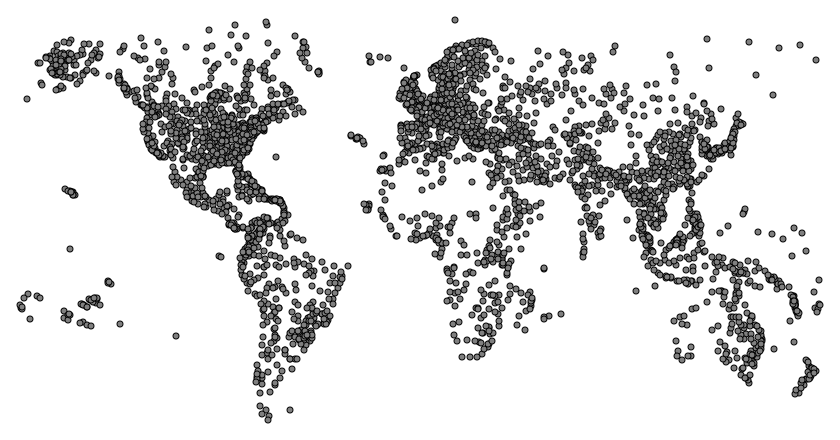

In [28]:
image = visualize_graph(adjacency, position, width=800, height=400, node_size=3, display_edges=False)
SVG(image)

## To do

* Display the same world map with the labels predicted for 3 seeds (Paris, New-York, Beijing), each with its own  label.
* Add Madrid with another label and comment the results.

In [29]:
paris = 622
newyork = 1842
beijing = 1618
madrid = 572

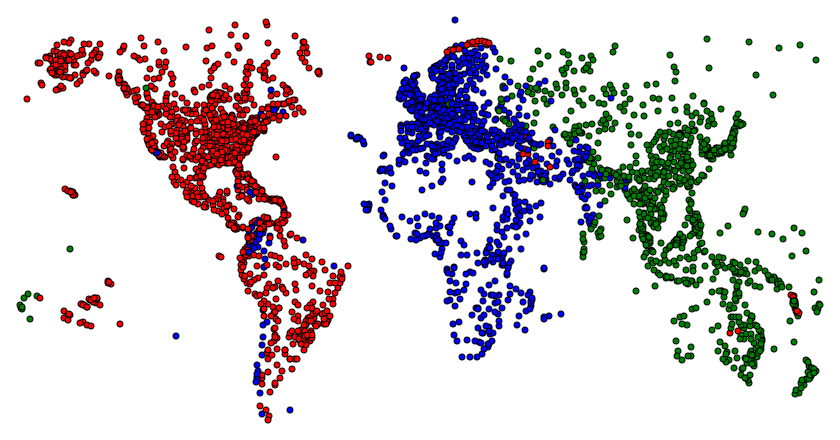

In [30]:
seeds = {paris: 0, newyork: 1, beijing: 2}
classifier = DiffusionClassifier()
labels_pred = classifier.fit_predict(adjacency, seeds)
image = visualize_graph(adjacency, position, labels=labels_pred, seeds=seeds, width=800, height=400, display_edges=False, node_size=3)
SVG(image)

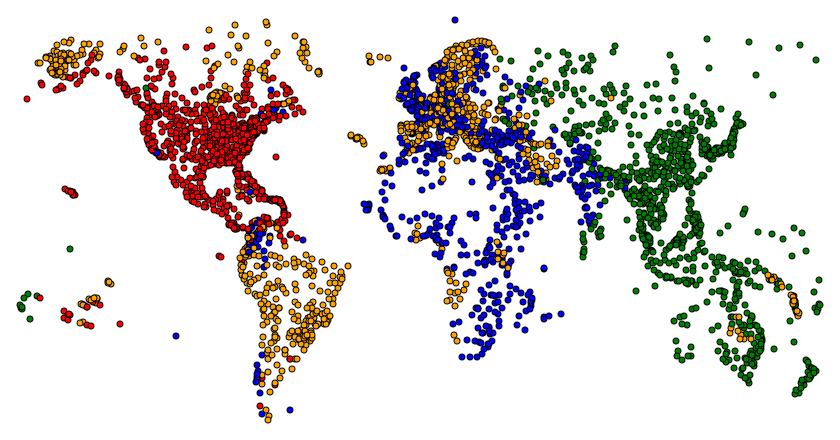

In [31]:
seeds = {paris: 0, newyork: 1, beijing: 2, madrid: 3}
classifier = DiffusionClassifier()
labels_pred = classifier.fit_predict(adjacency, seeds)
image = visualize_graph(adjacency, position, labels=labels_pred, seeds=seeds, width=800, height=400, display_edges=False, node_size=3)
SVG(image)

Finally, we illustrate **contrastive ranking** on Openflights.

## To do

* List the top-10 airports that are the closest to Tokyo in terms of Personalized PageRank.
* List of the top-10 airports that are both the closest to Tokyo and the furthest from Paris Charles de Gaulle, using heat diffusion (contrastive ranking).<br>What do you observe?
* Give the temperatures of these airports after heat diffusion and explain the result.

In [32]:
tokyo = 1084

In [33]:
pagerank = PageRank()
weight = {tokyo: 1}
scores = pagerank.fit_predict(adjacency, weights=weight)

top_10_scores = np.argsort(scores)[-10:][::-1]
top_10_airports = [str(names[i]) for i in top_10_scores]
print('Top 10 airports:')
for i, airport in enumerate(top_10_airports):
    print(f'{i + 1}. {airport} (score: {scores[top_10_scores[i]]})')

Top 10 airports:
1. Tokyo Haneda International Airport (score: 0.2007917247900593)
2. Incheon International Airport (score: 0.015925502142237865)
3. Naha Airport (score: 0.01461062225152516)
4. Taiwan Taoyuan International Airport (score: 0.01415457666110365)
5. Osaka International Airport (score: 0.012979127411549258)
6. Shanghai Pudong International Airport (score: 0.011456211982579045)
7. New Chitose Airport (score: 0.01114597873261842)
8. Kansai International Airport (score: 0.010016313604709873)
9. Narita International Airport (score: 0.009749384475681844)
10. Chubu Centrair International Airport (score: 0.009285629483342994)


In [34]:
# Paris Charles de Gaulle index is 'paris', Tokyo is 'tokyo'
# Set Paris as cold (0), Tokyo as hot (1)
values = {paris: 0, tokyo: 1}
dirichlet = Dirichlet()
temperatures = dirichlet.fit_predict(adjacency, values=values)

# Get top-10 nodes with highest temperature (close to Tokyo, far from Paris)
top_10_contrastive = np.argsort(temperatures)[-10:][::-1]
top_10_contrastive_airports = [str(names[i]) for i in top_10_contrastive]

print('Top 10 airports (close to Tokyo, far from Paris):')
for i, airport in enumerate(top_10_contrastive_airports):
    print(f'{i + 1}. {airport} (temperature: {temperatures[top_10_contrastive[i]]})')

Top 10 airports (close to Tokyo, far from Paris):
1. Iwami Airport (temperature: 1.0)
2. Shonai Airport (temperature: 1.0)
3. Monbetsu Airport (temperature: 1.0)
4. Tokachi-Obihiro Airport (temperature: 1.0)
5. Nanki Shirahama Airport (temperature: 1.0)
6. Izumo Airport (temperature: 1.0)
7. Tottori Airport (temperature: 1.0)
8. Tokushima Airport (temperature: 1.0)
9. Hachijojima Airport (temperature: 1.0)
10. Oshima Airport (temperature: 1.0)


All the top-10 airports have a temperature of 1.0 because they are directly connected to Tokyo or are in its immediate vicinity in the network, and they are far from Paris Charles de Gaulle.

## Wikipedia Vitals

We now consider the graph of links of WikiVitals, considered as undirected. We first focus on **constrastive ranking**, then on **node classification**.

In [35]:
dataset = wikivitals

In [36]:
adjacency = dataset.adjacency
names = dataset.names
labels = dataset.labels
names_labels = dataset.names_labels

In [37]:
adjacency = directed2undirected(adjacency)

## Contrastive ranking

## To do

* List the top-10 articles that are close to **Cat** and **Dog** in terms of Personalized PageRank.
* Compare with the list of top-10 articles that are close to **Cat** and **Dog** and far from **Bear** and **Tiger** using heat diffusion (contrastive ranking).
* List the top-10 articles that are close to **Bear** and **Tiger** and far from **Cat** and **Dog** (you can use previous diffusion). Interpret the results.

In [38]:
pagerank = PageRank()

In [49]:
cat_index = np.where(names == "Cat")[0][0]
dog_index = np.where(names == "Dog")[0][0]

weights = {cat_index: 1.0, dog_index: 1.0}
scores = pagerank.fit_predict(adjacency, weights=weights, force_bipartite=True)

top_10_scores = np.argsort(scores)[-10:][::-1]
top_10_articles = [str(names[i]) for i in top_10_scores]
print('Top 10 closest articles to Cat and Dog:')
for i, article in enumerate(top_10_articles):
    print(f'{i + 1}. {article} (score: {scores[top_10_scores[i]]})')

Top 10 closest articles to Cat and Dog:
1. Dog (score: 0.07618627955716155)
2. Cat (score: 0.0761017386594918)
3. Animal (score: 0.0009715668679416955)
4. Taxonomy (biology) (score: 0.0009475970330112)
5. Mammal (score: 0.0009376252171141569)
6. Coyote (score: 0.0007628966675023712)
7. Chordate (score: 0.0007360857084393408)
8. Lion (score: 0.0007186736905351634)
9. Pinniped (score: 0.0007109560851232494)
10. Tiger (score: 0.0007060313256099439)


In [55]:
bear_index = np.where(names == "Bear")[0][0]
tiger_index = np.where(names == "Tiger")[0][0]

values = {cat_index: 1, dog_index: 1, bear_index: 0, tiger_index: 0}
temperatures = dirichlet.fit_predict(adjacency, values=values)

top_10_contrastive = np.argsort(temperatures)[-10:][::-1]
top_10_contrastive_articles = [str(names[i]) for i in top_10_contrastive]
print('Top 10 articles (close to Cat and Dog, far from Bear and Tiger):')
for i, article in enumerate(top_10_contrastive_articles):
    print(f'{i + 1}. {article} (temperature: {temperatures[top_10_contrastive[i]]})')

Top 10 articles (close to Cat and Dog, far from Bear and Tiger):
1. Cat (temperature: 1.0)
2. Dog (temperature: 1.0)
3. Domestic short-haired cat (temperature: 0.6045304912817681)
4. Terrier (temperature: 0.6024188814740985)
5. Retriever (temperature: 0.5572718510330924)
6. Siamese cat (temperature: 0.5360099946920949)
7. Great Dane (temperature: 0.5293503938850092)
8. German Shepherd (temperature: 0.5290112448349082)
9. Skink (temperature: 0.5245124358057996)
10. Lyrebird (temperature: 0.5244796225024332)


In [57]:
top_10_contrastive = np.argsort(-temperatures)[-10:][::-1]
top_10_contrastive_articles = [str(names[i]) for i in top_10_contrastive]
print('Top 10 articles (close to Bear and Tiger, far from Cat and Dog):')
for i, article in enumerate(top_10_contrastive_articles):
    print(f'{i + 1}. {article} (temperature: {temperatures[top_10_contrastive[i]]})')

Top 10 articles (close to Bear and Tiger, far from Cat and Dog):
1. Tiger (temperature: 0.0)
2. Bear (temperature: 0.0)
3. Serranidae (temperature: 0.4688134893613958)
4. Stuffed toy (temperature: 0.4737704132658252)
5. Winnie-the-Pooh (temperature: 0.48020325087807253)
6. Hibernation (temperature: 0.4822355380333786)
7. Legendary creature (temperature: 0.4836050841751444)
8. Shaving (temperature: 0.4841047095784974)
9. Korean mythology (temperature: 0.4845051249831427)
10. Mount St. Helens (temperature: 0.4879566017776237)


## Node classification

We now use the ground-truth labels provided by the category of each article.

In [58]:
print(names_labels)

['Arts' 'Biological and health sciences' 'Everyday life' 'Geography'
 'History' 'Mathematics' 'People' 'Philosophy and religion'
 'Physical sciences' 'Society and social sciences' 'Technology']


## To do

* What is the accuracy of node classification, using half of the nodes in the train set?
* Display the confusion matrix. What is the most difficult class to predict?
* Give examples of misclassification for each label (e.g., 2 false positives and 2 false negatives per label).

In [ ]:
n = len(labels)
seeds = -np.ones(n, dtype=int)

for label in np.unique(labels):
    idx = np.where(labels == label)[0]
    n_train = len(idx) // 2
    train_idx = np.random.choice(idx, n_train, replace=False)
    seeds[train_idx] = label

classifier = DiffusionClassifier()
labels_pred = classifier.fit_predict(adjacency, seeds)

accuracy = np.mean(labels_pred == labels)
print(f"Accuracy with half nodes as train set: {accuracy:.4f}")

Accuracy with half nodes as train set: 0.8739


In [60]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

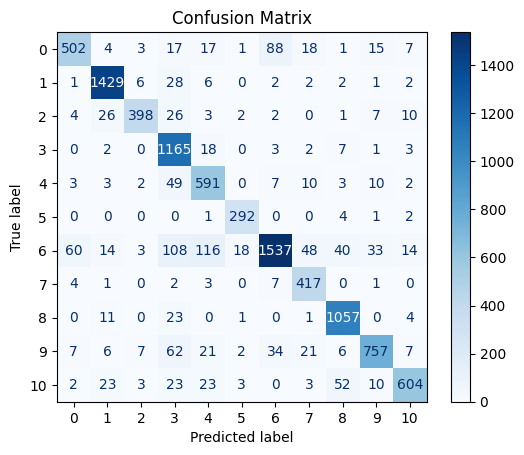

In [61]:
cm = confusion_matrix(labels, labels_pred, labels=np.unique(labels))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(labels))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [62]:
errors = cm.sum(axis=1) - np.diag(cm)
worst_class = np.argmax(errors)
print(f"The most difficult class to predict is: {worst_class} (with {errors[worst_class]} errors)")

The most difficult class to predict is: 6 (with 454 errors)


In [63]:
labels_unique = np.unique(labels)

for label in labels_unique:
    # false positives: predicted 'label' but true != 'label'
    fp_idx = np.where((labels_pred == label) & (labels != label))[0][:2]
    # false negatives: true 'label' but predicted != 'label'
    fn_idx = np.where((labels == label) & (labels_pred != label))[0][:2]
    
    print(f"\nLabel {label}:")
    print("  False positives:")
    for idx in fp_idx:
        print(f"    Index {idx}: predicted={labels_pred[idx]}, true={labels[idx]}, name={names[idx]}")
    print("  False negatives:")
    for idx in fn_idx:
        print(f"    Index {idx}: predicted={labels_pred[idx]}, true={labels[idx]}, name={names[idx]}")


Label 0:
  False positives:
    Index 67: predicted=0, true=6, name=Abu Nuwas
    Index 101: predicted=0, true=2, name=Action figure
  False negatives:
    Index 16: predicted=6, true=0, name=8½
    Index 17: predicted=6, true=0, name=A Christmas Carol

Label 1:
  False positives:
    Index 122: predicted=1, true=2, name=Adolescence
    Index 177: predicted=1, true=10, name=Agronomy
  False negatives:
    Index 163: predicted=2, true=1, name=Agave
    Index 329: predicted=3, true=1, name=Alstroemeria

Label 2:
  False positives:
    Index 163: predicted=2, true=1, name=Agave
    Index 936: predicted=2, true=0, name=Batman
  False negatives:
    Index 2: predicted=3, true=2, name=100 metres
    Index 101: predicted=0, true=2, name=Action figure

Label 3:
  False positives:
    Index 2: predicted=3, true=2, name=100 metres
    Index 4: predicted=3, true=4, name=1556 Shaanxi earthquake
  False negatives:
    Index 251: predicted=4, true=3, name=Aleppo
    Index 555: predicted=4, true=3, 

## To do

* Classify each article of the **People** category in one of the other categories (Mathematics, History, etc.), using all other labels.
* List the top-5 predicted people of each category using Personalized PageRank.

In [70]:
people_index = np.where(names_labels == "People")[0][0]
people_label = np.where(np.unique(labels) == people_index)[0][0] if people_index in np.unique(labels) else people_index

idx_people = np.where(labels == people_index)[0]

seeds = -np.ones(len(labels), dtype=int)
for label in np.unique(labels):
    if label == people_index:
        continue
    idx = np.where(labels == label)[0]
    seeds[idx] = label

classifier = DiffusionClassifier()
labels_pred = classifier.fit_predict(adjacency, seeds)

print("Predicted categories for People articles:")
for idx in idx_people:
    pred_label = labels_pred[idx]
    pred_category = names_labels[pred_label]
    print(f"{names[idx]}: predicted category = {pred_category}")

Predicted categories for People articles:
14th Dalai Lama: predicted category = Society and social sciences
A. C. Bhaktivedanta Swami Prabhupada: predicted category = Philosophy and religion
A. J. Foyt: predicted category = Geography
A. J. P. Taylor: predicted category = History
ABBA: predicted category = Arts
Aaron Copland: predicted category = Arts
Abbas Kiarostami: predicted category = Arts
Abbas the Great: predicted category = Geography
Abd al-Malik ibn Marwan: predicted category = History
Abd al-Rahman I: predicted category = Geography
Abd al-Rahman III: predicted category = Geography
Abdul Hamid II: predicted category = Geography
Abdulaziz of Saudi Arabia: predicted category = Geography
Abel Tasman: predicted category = Geography
Abraham Lincoln: predicted category = Society and social sciences
Abraham Maslow: predicted category = Society and social sciences
Abu Bakr: predicted category = Philosophy and religion
Abu Hanifa: predicted category = Philosophy and religion
Abu Muslim:

In [71]:
pagerank = PageRank()
categories = [i for i in np.unique(labels_pred) if i != people_index]

for cat in categories:
    # Indices des personnes prédites dans cette catégorie
    idx_people_cat = idx_people[labels_pred[idx_people] == cat]
    if len(idx_people_cat) == 0:
        continue
    # Personalized PageRank sur ces personnes
    weights = {idx: 1 for idx in idx_people_cat}
    scores = pagerank.fit_predict(adjacency, weights=weights)
    # Top 5 personnes de cette catégorie selon PageRank
    top5 = idx_people_cat[np.argsort(scores[idx_people_cat])[::-1][:5]]
    print(f"\nTop 5 predicted people in category '{names_labels[cat]}':")
    for idx in top5:
        print(f"  {names[idx]}")


Top 5 predicted people in category 'Arts':
  Bob Dylan
  Barbra Streisand
  Fred Astaire
  Judy Garland
  Martin Scorsese

Top 5 predicted people in category 'Biological and health sciences':
  Konrad Lorenz
  Francis Crick
  Charles Darwin
  Antonie van Leeuwenhoek
  James Watson

Top 5 predicted people in category 'Everyday life':
  Wayne Gretzky
  Babe Ruth
  Jackie Robinson
  Jim Thorpe
  Willie Mays

Top 5 predicted people in category 'Geography':
  Carl Lewis
  Martina Navratilova
  Steffi Graf
  Pelé
  Michael Phelps

Top 5 predicted people in category 'History':
  Alexander the Great
  Napoleon
  Charlemagne
  Philip II of Spain
  Charles V, Holy Roman Emperor

Top 5 predicted people in category 'Mathematics':
  Leonhard Euler
  Bernhard Riemann
  Henri Poincaré
  Archimedes
  Euclid

Top 5 predicted people in category 'Philosophy and religion':
  Augustine of Hippo
  Thomas Aquinas
  Aristotle
  Plato
  Immanuel Kant

Top 5 predicted people in category 'Physical sciences':
  

## 2. Bipartite graphs

Finally, we consider the bipartite graph between articles and words in WikiVitals.

In [72]:
dataset = wikivitals
biadjacency = dataset.biadjacency

In [73]:
words = dataset.names_col

## To do

* Repeat the experiments on node classification using the bipartite graph between articles and words.
* Which information seems to be richer, the text or the links between articles?
* Propose a solution exploiting both sources of information.

In [ ]:
n_articles = biadjacency.shape[0]
labels_bipartite = labels  

seeds = -np.ones(n_articles, dtype=int)
for label in np.unique(labels_bipartite):
    idx = np.where(labels_bipartite == label)[0]
    n_train = len(idx) // 2
    train_idx = np.random.choice(idx, n_train, replace=False)
    seeds[train_idx] = label

classifier = DiffusionClassifier()
labels_pred_bipartite = classifier.fit_predict(biadjacency, seeds)

accuracy_bipartite = np.mean(labels_pred_bipartite == labels_bipartite)
print(f"Accuracy with bipartite graph (articles-words): {accuracy_bipartite:.4f}")

Accuracy with bipartite graph (articles-words): 0.9003


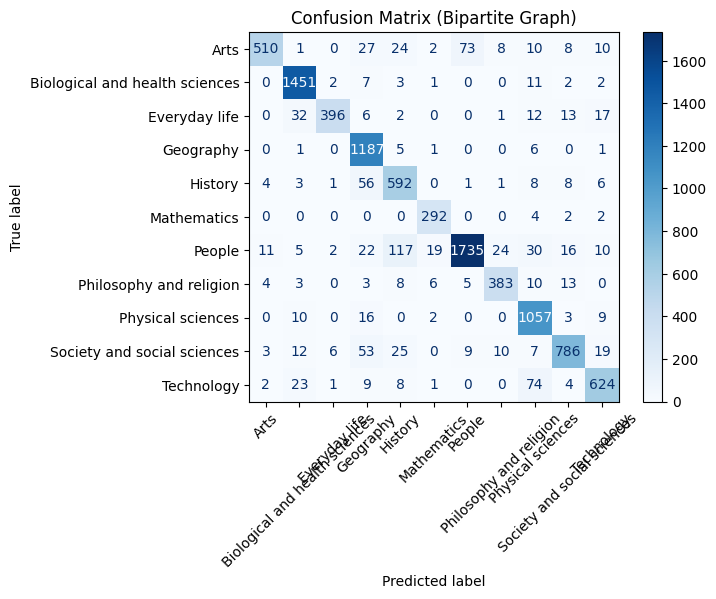

In [75]:
# Compute and display the confusion matrix
cm = confusion_matrix(labels_bipartite, labels_pred_bipartite, labels=labels_unique)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=names_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title('Confusion Matrix (Bipartite Graph)')
plt.show()

In [76]:
# Identify the most difficult class to predict
errors = cm.sum(axis=1) - np.diag(cm)
worst_class = np.argmax(errors)
print(f"The most difficult class to predict is: {names_labels[worst_class]} (with {errors[worst_class]} errors)")

The most difficult class to predict is: People (with 256 errors)


In [77]:
# Show examples of misclassification for each label
for label in labels_unique:
    # False positives: predicted as 'label' but true != 'label'
    fp_idx = np.where((labels_pred_bipartite == label) & (labels_bipartite != label))[0][:2]
    # False negatives: true 'label' but predicted != 'label'
    fn_idx = np.where((labels_bipartite == label) & (labels_pred_bipartite != label))[0][:2]
    
    print(f"\nLabel '{names_labels[label]}':")
    print("  False positives:")
    for idx in fp_idx:
        print(f"    Index {idx}: predicted={names_labels[labels_pred_bipartite[idx]]}, true={names_labels[labels_bipartite[idx]]}, name={names[idx]}")
    print("  False negatives:")
    for idx in fn_idx:
        print(f"    Index {idx}: predicted={names_labels[labels_pred_bipartite[idx]]}, true={names_labels[labels_bipartite[idx]]}, name={names[idx]}")


Label 'Arts':
  False positives:
    Index 540: predicted=Arts, true=People, name=Antonio Stradivari
    Index 1164: predicted=Arts, true=Technology, name=Book
  False negatives:
    Index 16: predicted=People, true=Arts, name=8½
    Index 59: predicted=Mathematics, true=Arts, name=Abstract art

Label 'Biological and health sciences':
  False positives:
    Index 49: predicted=Biological and health sciences, true=Society and social sciences, name=Abortion
    Index 242: predicted=Biological and health sciences, true=Everyday life, name=Alcoholic drink
  False negatives:
    Index 103: predicted=Physical sciences, true=Biological and health sciences, name=Active transport
    Index 696: predicted=Geography, true=Biological and health sciences, name=Astacus astacus

Label 'Everyday life':
  False positives:
    Index 2868: predicted=Everyday life, true=People, name=Eric Heiden
    Index 2941: predicted=Everyday life, true=Society and social sciences, name=Euphemism
  False negatives:
  

In general, the links between articles provide richer information for node classification because they reflect human-curated relationships and thematic structure. However, the text (article-word bipartite graph) can be more informative for distinguishing closely related topics or when articles have few links. Combining both sources usually gives the best results.